In [1]:
import logging

import pickle

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns
from pyro import poutine
from sklearn import metrics

In [2]:
pyro.set_rng_seed(10)

In [3]:
class PMF(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self,data, train, dim,alpha):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = data.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None
        self.returned = None
        self.a = alpha
        self.predictive_svi = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()
        
        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
        self.bias = self.data.mean()


    def model(self, train, mask):
        a = 50

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(self.alpha_u, self.beta_u).expand([self.dim]).to_event(1))
            #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
        
        with sideeffect_plate:
            VA = pyro.sample("VA", dist.Gamma(self.alpha_v, self.beta_v).expand([self.dim]).to_event(1))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

        with sideeffect_plate, u2_plate: 
            with pyro.poutine.mask(mask=mask):
             Y = pyro.sample("target", dist.NegativeBinomial(self.a, UA@VA.T/( UA@VA.T+self.a) ), obs=train ) 
             return Y
        

    def guide(self, train=None, mask=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)
       # int_mean = pyro.param('int_mean', torch.tensor(1.)*self.user_mean)
       # mov_cov = pyro.param('mov_cov', torch.tensor(1.)*0.1,
          #                  constraint=constraints.positive)

        s_alpha = pyro.param('s_alpha', torch.ones(self.m,self.dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones(self.m,self.dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(d_alpha, d_beta).to_event(1))
           # UA_int = pyro.sample("UAint", dist.Normal(int_mean, mov_cov).to_event(1))
        with sideeffect_plate: 
            VA = pyro.sample("VA", dist.Gamma(s_alpha, s_beta).to_event(1))
    
    def train_SVI(self,train,mask, nsteps=250, lr = 0.05, lrd = 1, verbose=True):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float(), mask)
            losses.append(elbo)
            if(verbose):
                if step % 10 == 0:
                    print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        unmasked =torch.ones((self.n,self.m), dtype=torch.bool)
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)(None , unmasked)
        self.predictive_svi = predictive_svi
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        self.returned = table
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)

        self.predictions = mc_table

    def predictive_score(self,test,masked):
        # total = test.shape[0]*test.shape[1]
        
        UA =  self.predictive_svi["UA"]
        VA = self.predictive_svi["VA"]
        VA = VA.mean(axis=0).reshape(self.m,self.dim)
        UA = UA.mean(axis=0).reshape(self.n,self.dim)
        print(UA.shape)
        score = dist.NegativeBinomial(self.a, UA@VA.T/( UA@VA.T+self.a)).log_prob(torch.from_numpy(test))
        mean_score = (score*masked).reshape(-1).logsumexp(-1) -np.log(test.shape[0]*test.shape[1])
        return mean_score

 
    
    def rmse(self,test,masked,h):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < h] = low
        test_data[test_data >= h] = high
        size = masked.sum()
        predictions = self.predictions
        predictions[predictions < h] = low
        predictions[predictions >= h] = high
        sqerror = abs(test_data[masked] - predictions[masked]) ** 2  # squared error array
        mse = sqerror.sum()/size
        print("PMF  RMSE: " , np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data[masked].astype(int).flatten(),  predictions[masked].astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return (self.returned,self.predictions)

    def get_predictive_svi(self):
         return (self.predictive_svi)

    
   
       

In [4]:

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.shape)



with open('data_train.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)


nan_mask = np.isnan(data2) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
print(torch.from_numpy(nan_mask) )


(1127, 5237)
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
(1127, 5237)


In [13]:

def predictive_score_for_diim_estimation(data_all, train, classname):
    score=[]
    for d in [1,5,10,20,50,75,100,200,250]:
        nan_mask = np.isnan(train) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
        test = classname(data_all,train, d,50)  
        pyro.clear_param_store()
        test.train_SVI(data_all , ~torch.from_numpy(nan_mask), verbose = False)
        test.sample_predict(250)
        score.append(test.predictive_score(data_all,  torch.from_numpy(nan_mask)))
    return score

s = predictive_score_for_diim_estimation(data,data2, PMF)


UA: (250, 1, 1127, 1)
VA: (250, 1, 5237, 1)
target: (250, 1127, 5237)
torch.Size([1127, 1])
UA: (250, 1, 1127, 5)
VA: (250, 1, 5237, 5)
target: (250, 1127, 5237)
torch.Size([1127, 5])
UA: (250, 1, 1127, 10)
VA: (250, 1, 5237, 10)
target: (250, 1127, 5237)
torch.Size([1127, 10])
UA: (250, 1, 1127, 20)
VA: (250, 1, 5237, 20)
target: (250, 1127, 5237)
torch.Size([1127, 20])
UA: (250, 1, 1127, 50)
VA: (250, 1, 5237, 50)
target: (250, 1127, 5237)
torch.Size([1127, 50])
UA: (250, 1, 1127, 75)
VA: (250, 1, 5237, 75)
target: (250, 1127, 5237)
torch.Size([1127, 75])
UA: (250, 1, 1127, 100)
VA: (250, 1, 5237, 100)
target: (250, 1127, 5237)
torch.Size([1127, 100])
UA: (250, 1, 1127, 200)
VA: (250, 1, 5237, 200)
target: (250, 1127, 5237)
torch.Size([1127, 200])
UA: (250, 1, 1127, 250)
VA: (250, 1, 5237, 250)
target: (250, 1127, 5237)
torch.Size([1127, 250])


In [10]:
def predictive_score_for_alpha_estimation(data_all, train, classname):
    score=[]
    for alpha in [0.1,1,5,10,50,100]:
        nan_mask = np.isnan(train) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
        test = classname(data_all,train, 50,alpha)  
        pyro.clear_param_store()
        test.train_SVI(data_all , ~torch.from_numpy(nan_mask), verbose = False)
        test.sample_predict(500)
        score.append(test.predictive_score(data_all,  torch.from_numpy(nan_mask)))
    return score
a = predictive_score_for_alpha_estimation(data,data2, PMF)


UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])
UA: (500, 1, 1127, 50)
VA: (500, 1, 5237, 50)
target: (500, 1127, 5237)
torch.Size([1127, 50])


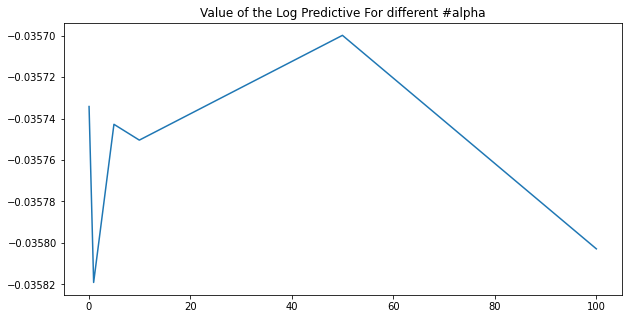

In [11]:
alpha= [0.1,1,5,10,50,100]
plt.figure(figsize=(10, 5))
plt.plot(alpha, a)
plt.title("Value of the Log Predictive For different #alpha")
plt.savefig("predictive_score_NB_alpha.png")
plt.show()
pyro.clear_param_store()

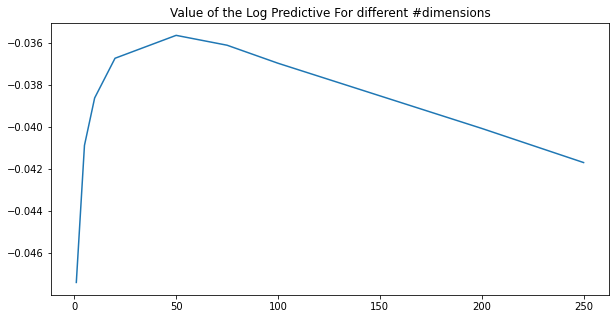

In [14]:
d = [1,5,10,20,50,75,100,200,250]
plt.figure(figsize=(10, 5))
plt.plot(d, s)
plt.title("Value of the Log Predictive For different #dimensions")
#plt.savefig("predictive_score_NB.png")
plt.show()
pyro.clear_param_store()

In [15]:
nan_mask = np.isnan(data2) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
print(torch.from_numpy(nan_mask) )
test = PMF(data,data2, dim=50,alpha=50)
l = test.train_SVI(data, ~torch.from_numpy(nan_mask))


tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False,  True, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
Elbo loss: 405500224.53125
Elbo loss: 115197524.69921875
Elbo loss: 35198120.546875
Elbo loss: 19236216.850585938
Elbo loss: 15544050.41015625
Elbo loss: 14479018.65234375
Elbo loss: 14029841.0234375
Elbo loss: 13613842.18359375
Elbo loss: 13089588.421875
Elbo loss: 12428949.18359375
Elbo loss: 11681372.3671875
Elbo loss: 11192034.4765625
Elbo loss: 10756102.0625
Elbo loss: 10523469.0859375
Elbo loss: 10271218.46875
Elbo loss: 10057997.7421875
Elbo loss: 9960022.4140625
Elbo loss: 9765674.234375
Elbo loss: 9666474.140625
Elbo loss: 9513552.1171875
Elbo loss: 9436160.5234375
Elbo loss: 9350026.0859375
Elbo loss: 9305454.265625
Elbo

In [16]:
los = test.train_SVI(data, ~torch.from_numpy(nan_mask))

Elbo loss: 9144112.8515625
Elbo loss: 9083458.390625
Elbo loss: 9029458.2421875
Elbo loss: 8984110.40625
Elbo loss: 8935386.4296875
Elbo loss: 8888816.734375
Elbo loss: 8826415.70703125
Elbo loss: 8821849.8125
Elbo loss: 8671228.52734375
Elbo loss: 8716352.1640625
Elbo loss: 8711480.88671875
Elbo loss: 8651859.9296875
Elbo loss: 8621077.65625
Elbo loss: 8648886.1875
Elbo loss: 8638812.59765625
Elbo loss: 8579637.734375
Elbo loss: 8547789.01953125
Elbo loss: 8520633.23828125
Elbo loss: 8501789.8203125
Elbo loss: 8441774.609375
Elbo loss: 8455186.03515625
Elbo loss: 8473720.5859375
Elbo loss: 8488552.4140625
Elbo loss: 8446638.76953125
Elbo loss: 8492015.90625


In [17]:
test.sample_predict(300)

UA: (300, 1, 1127, 50)
VA: (300, 1, 5237, 50)
target: (300, 1127, 5237)


In [18]:
nan_mask = np.isnan(data2)
#test rmse
test.rmse(data, nan_mask,1)
#train rmse
test.rmse(data, ~nan_mask,1)

PMF  RMSE:  0.34661532989789495
AUC: 0.83255
PMF  RMSE:  0.3392088201407181
AUC: 0.83825


(0.3392088201407181, 0.8382533082694894)

In [19]:
#test rmse
test.rmse(data, nan_mask,4)
#train rmse
test.rmse(data, ~nan_mask,4)

PMF  RMSE:  0.2935781208202841
AUC: 0.50000
PMF  RMSE:  0.29386885556227027
AUC: 0.50000


(0.29386885556227027, 0.5)

In [20]:
Simple_PMF ={}
Simple_PMF['losses'] = l + los
Simple_PMF['predictive_score'] = d
Simple_PMF['train_rmse'] = 0.331
Simple_PMF['test_rmse'] = 0.336
Simple_PMF['AUC'] = 0.838
Simple_PMF['train_rmse_3'] = 0.2938
Simple_PMF['test_rmse_3'] = 0.2935
Simple_PMF['predictions'] = test.get_predictions()

In [21]:
with open('SVI_negative_binomial.pickle', 'wb') as handle:
    pickle.dump(Simple_PMF, handle, protocol=pickle.HIGHEST_PROTOCOL)